In [1]:
import gensim
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, hamming_loss, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_excel('/Users/suhas.kamuni/Downloads/Merged_Training_Set.xlsx')
df.drop(['Platform.1'], axis = 1)
# df = pd.read_excel('/Users/suhas.kamuni/Downloads/Training_Set.xlsx')

,Review ID,Reviews Content,Converted English,Rating,Start Date,Version,Platform,Source,Month,Predicted Team
0,158994127,Keine vernünftige Struktur wie bei Web Version...,Not a reasonable structure as with web version...,1,21.10.2022,NaN,Android,EasyFeedback,September,People/Homepage
1,158999921,Ich finde vorher war übersicht besser.,I think before was overview better.,2,21.10.2022,NaN,Android,EasyFeedback,September,Design System
2,159009543,Teilweise mühsame Navigation,Partly tedious navigation,3,22.10.2022,NaN,Android,EasyFeedback,September,General
3,159010950,Unpraktische Bedienung,Impractical operation,2,22.10.2022,NaN,Android,EasyFeedback,September,General
4,159033855,"Mich stört, dass laufend irgendwelche Besucher...",It bothers me that some visitors can constantl...,2,22.10.2022,NaN,Android,EasyFeedback,September,Profile
...,...,...,...,...,...,...,...,...,...,...
1788,169331349,Viel zu teuer - möchte kündigen - keine Option...,Way too expensive - want to cancel - no option...,3,25.03.2023 | 12:43,NaN,iOS,EasyFeedback,March,CPAY
1789,170340338,"Zu teuer, zu viel Werbung.","Too expensive, too much advertising.",2,08.04.2023 | 08:33,NaN,Android,EasyFeedback,April,CPAY
1790,171527475,Kosten,Cost,3,25.04.2023 | 19:23,NaN,Android,EasyFeedback,April,CPAY
1791,a03f98f6-bb97-4e90-8885-de666236e05e,Einfach unverschämt diese App. Geld für ein Ja...,Simply outrageous this app. Pull out money for...,1,2023-05-30 00:00:00,23.13.1m,Android,Data.AI,May,CPAY


In [1]:
df

NameError: name 'df' is not defined

In [3]:
import re
import string 
from wordcloud import WordCloud, STOPWORDS

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

def clean_text(input_txt):
    input_txt = input_txt.str.replace("[^a-zA-Z#]", " ") # removes special chars
    input_txt = input_txt.str.strip() # removes white spaces
    input_txt = input_txt.str.lower() # converts to lower case
    input_txt = input_txt.fillna('') 

    p = string.punctuation
    table = str.maketrans('','',p)
    #df['data'] = df.fillna({'data':''})
    input_txt = input_txt.apply(lambda x:x.translate(table))
    input_txt = input_txt.apply(lambda x:x.split(' ')) #tokenising each word

    stopwords = set(STOPWORDS) 
    input_txt = input_txt.apply(lambda x: [word for word in x if word not in stopwords]) # removing stopwords

    ps = nltk.PorterStemmer() # stem the thing
    input_txt = input_txt.apply(lambda x: [ps.stem(word) for word in x])
    input_txt = input_txt.apply(lambda x: ' '.join([word for word in x if len(word) > 1])) # removing single letter

    input_txt = np.vectorize(remove_pattern)(input_txt, "@[\w]*")

    return input_txt

In [4]:
# Clean data using the built in cleaner in gensim
# df['text_clean'] = clean_text(df['Converted English'])
df['text_clean'] = df['Converted English'].apply(lambda x: gensim.utils.simple_preprocess(x)) # removes punctuation, stopwords and tokenizes the sentence
df.head()

,Review ID,Reviews Content,Converted English,Rating,Start Date,Version,Platform,Platform.1,Source,Month,Predicted Team,text_clean
0,158994127,Keine vernünftige Struktur wie bei Web Version...,Not a reasonable structure as with web version...,1,21.10.2022,NaN,Android,Android,EasyFeedback,September,People/Homepage,"[not, reasonable, structure, as, with, web, ve..."
1,158999921,Ich finde vorher war übersicht besser.,I think before was overview better.,2,21.10.2022,NaN,Android,Android,EasyFeedback,September,Design System,"[think, before, was, overview, better]"
2,159009543,Teilweise mühsame Navigation,Partly tedious navigation,3,22.10.2022,NaN,Android,Android,EasyFeedback,September,General,"[partly, tedious, navigation]"
3,159010950,Unpraktische Bedienung,Impractical operation,2,22.10.2022,NaN,Android,Android,EasyFeedback,September,General,"[impractical, operation]"
4,159033855,"Mich stört, dass laufend irgendwelche Besucher...",It bothers me that some visitors can constantl...,2,22.10.2022,NaN,Android,Android,EasyFeedback,September,Profile,"[it, bothers, me, that, some, visitors, can, c..."


In [5]:
# Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split (df['text_clean'], df['Predicted Team'] , test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split (df['Converted English'], df['Predicted Team'] , test_size=0.2)

In [6]:
# Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=100,
                                   window=5,
                                   min_count=20)

In [7]:
w2v_model.wv.index_to_key

[' ',
 'e',
 't',
 'o',
 'n',
 'a',
 'i',
 's',
 'r',
 'l',
 'h',
 'd',
 'c',
 'u',
 'm',
 'p',
 'g',
 'f',
 'y',
 '.',
 'b',
 'w',
 'v',
 ',',
 'I',
 'k',
 'T',
 "'",
 'N',
 'C',
 'A',
 'j',
 '-',
 '!',
 'X',
 'x',
 'L',
 'P',
 'S',
 'G',
 '"',
 'W',
 'U',
 'O',
 'F',
 'M',
 'q',
 'B',
 '?',
 'H',
 ')',
 'E',
 'D',
 'Y',
 '2',
 '(',
 '1',
 '0',
 'R',
 'z',
 '3',
 ':',
 '/',
 'J',
 'V',
 ';']

In [8]:
def pipe_try(xx_test, yy_test, model):
    print('========================== {} ==========================\n'.format(model))
    print("\t \t \t\t \t------------------")
    print("\t \t \t \t \tF1 Score: ", round(f1_score(yy_test, model.predict(xx_test), average='macro')*100,2),"%")
    print("\t \t \t\t \tAccuracy: ", round(metrics.accuracy_score(yy_test, model.predict(xx_test))*100,2),"%")
    print("    \t \t \t \t       Hamming Loss: ", round(hamming_loss(yy_test, model.predict(xx_test)), 2))
    print("    \t \t \t \t   Weighted F1 Score: ",round(f1_score(yy_test, model.predict(xx_test), average='weighted')*100,2),"%")
    print("    \t \t \t \t   ---------------------------\n")
    print('================================= Pipeline Specifications ==================================')
    print(model)

In [9]:
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

/var/folders/hg/fs173qbn7kj8l_ytbdcwfr0r0000gp/T/ipykernel_9200/22094319.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
/var/folders/hg/fs173qbn7kj8l_ytbdcwfr0r0000gp/T/ipykernel_9200/22094319.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])


In [10]:
# Why is the length of the sentence different than the length of the sentence vector?
for i, v in enumerate(X_train_vect):
    print(len(X_train.iloc[i]), len(v))

132 132
126 126
47 47
90 90
53 53
71 71
78 78
254 254
25 25
32 32
6 6
34 34
113 113
150 150
49 49
112 112
27 27
83 83
59 59
224 224
78 78
78 78
297 297
42 42
44 44
24 24
99 99
33 33
215 215
33 33
57 57
65 65
44 44
19 19
53 53
26 26
208 208
317 317
138 138
99 99
158 158
30 30
105 105
365 362
82 82
24 24
81 81
55 55
83 83
625 624
95 95
10 10
137 136
163 163
44 44
122 121
217 217
48 48
34 34
77 77
210 210
291 291
195 195
30 30
79 79
130 129
51 51
73 73
23 23
80 79
332 332
6 6
86 86
31 31
182 182
40 40
171 171
98 98
34 34
100 100
88 88
394 394
99 99
43 43
56 56
65 65
240 240
32 32
26 26
1060 1060
74 74
56 56
165 165
64 64
55 55
165 165
11 11
73 73
198 198
132 132
34 34
20 20
50 50
297 297
179 179
53 53
58 58
49 49
139 139
14 14
53 53
43 43
15 15
76 76
20 20
245 244
87 87
39 39
37 37
80 80
19 19
63 63
135 134
49 49
270 270
54 54
681 681
164 164
75 75
108 108
23 23
56 56
128 128
74 73
27 27
94 94
167 167
96 96
23 23
25 25
90 90
63 63
78 78
62 62
22 22
332 332
157 155
79 79
56 56
50 50
14 14


In [11]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [12]:
# Are our sentence vector lengths consistent?
for i, v in enumerate(X_train_vect_avg):
    print(len(X_train.iloc[i]), len(v))

132 100
126 100
47 100
90 100
53 100
71 100
78 100
254 100
25 100
32 100
6 100
34 100
113 100
150 100
49 100
112 100
27 100
83 100
59 100
224 100
78 100
78 100
297 100
42 100
44 100
24 100
99 100
33 100
215 100
33 100
57 100
65 100
44 100
19 100
53 100
26 100
208 100
317 100
138 100
99 100
158 100
30 100
105 100
365 100
82 100
24 100
81 100
55 100
83 100
625 100
95 100
10 100
137 100
163 100
44 100
122 100
217 100
48 100
34 100
77 100
210 100
291 100
195 100
30 100
79 100
130 100
51 100
73 100
23 100
80 100
332 100
6 100
86 100
31 100
182 100
40 100
171 100
98 100
34 100
100 100
88 100
394 100
99 100
43 100
56 100
65 100
240 100
32 100
26 100
1060 100
74 100
56 100
165 100
64 100
55 100
165 100
11 100
73 100
198 100
132 100
34 100
20 100
50 100
297 100
179 100
53 100
58 100
49 100
139 100
14 100
53 100
43 100
15 100
76 100
20 100
245 100
87 100
39 100
37 100
80 100
19 100
63 100
135 100
49 100
270 100
54 100
681 100
164 100
75 100
108 100
23 100
56 100
128 100
74 100
27 100
94 100
167 

In [13]:
# Instantiate and fit a basic Random Forest model on top of the vectors
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

In [14]:
X_train_vect_avg

[array([-0.11492901,  0.1098915 ,  0.24718755,  0.15863283,  0.12604548,
        -0.09153077,  0.04069898,  0.1093019 , -0.15701312, -0.13736257,
         0.17386842, -0.17384627,  0.00567221, -0.06555922,  0.10902791,
         0.02632546,  0.08139013,  0.12669127, -0.04602705, -0.34987828,
         0.0839596 ,  0.04293094,  0.2724825 , -0.18423809, -0.03188812,
         0.16088034, -0.1621285 ,  0.23153949,  0.00887145, -0.06909304,
         0.02104597, -0.04136306, -0.00470666,  0.04822317,  0.02516684,
         0.01218326,  0.22832233,  0.01356636, -0.0790464 ,  0.08022913,
         0.3307805 , -0.13909566, -0.19549213,  0.08387604, -0.05324788,
        -0.0041974 , -0.16519725,  0.00796572,  0.05692462,  0.01434771,
         0.06386554, -0.19254866, -0.00758567,  0.05772781, -0.17570977,
        -0.00290678,  0.12031544,  0.0174427 ,  0.07117156,  0.07239541,
        -0.1576866 ,  0.04515016,  0.28382117, -0.08780182, -0.04866954,
         0.15464951,  0.08760673,  0.19551232, -0.1

In [15]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)

In [16]:
print(metrics.classification_report(y_test, y_pred))

                      precision    recall  f1-score   support

                 Ads       0.62      0.22      0.32        23
                CPAY       0.00      0.00      0.00         5
Content Architecture       0.00      0.00      0.00        20
       Design System       0.00      0.00      0.00        18
             General       0.39      0.88      0.54       122
            Insights       0.50      0.07      0.12        15
                Jobs       0.17      0.06      0.08        18
 LinkedIn comparison       0.67      0.40      0.50        15
           Messenger       0.00      0.00      0.00        17
        Notification       0.00      0.00      0.00        10
     People/Homepage       0.11      0.14      0.12        29
             Premium       0.17      0.04      0.07        24
             Profile       0.12      0.06      0.08        18
 Reference to Groups       0.00      0.00      0.00        15
              Upsell       0.00      0.00      0.00        10

      

/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [17]:
pipe_try(X_test_vect_avg, y_test, rf_model)

========================== RandomForestClassifier() ==========================

	 	 		 	------------------
	 	 	 	 	F1 Score:  12.21 %
	 	 		 	Accuracy:  35.1 %
    	 	 	 	       Hamming Loss:  0.65
    	 	 	 	   Weighted F1 Score:  25.33 %
    	 	 	 	   ---------------------------

================================= Pipeline Specifications ==================================
RandomForestClassifier()


Text(0.5, 1.0, 'Confusion Matrix\n')

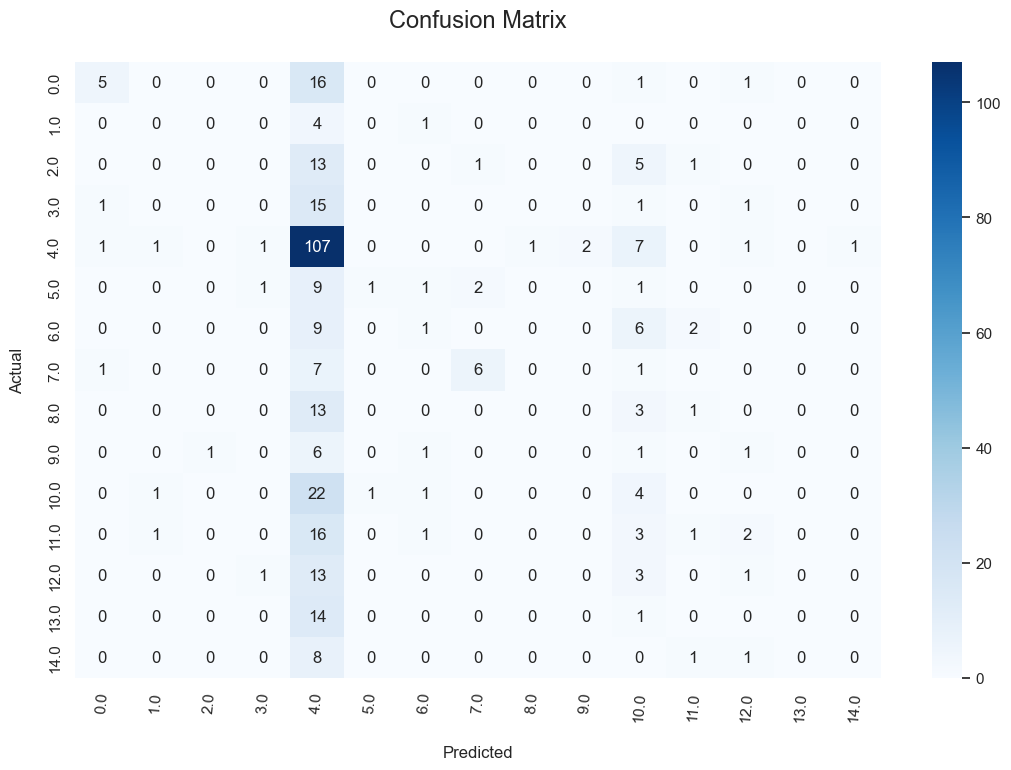

In [18]:
sns.set(font_scale=1.0)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(13,8))

sns.heatmap(cm, 
            annot=True, 
            cmap="Blues", 
            fmt='d',
            xticklabels = rf_model[-1].classes_,
            yticklabels = rf_model[-1].classes_,
            )

plt.ylabel('Actual\n')
plt.xlabel('\nPredicted')
plt.xticks(rotation = 85)
plt.title("Confusion Matrix\n", size = 17)

In [19]:
LR_502 = LogisticRegression(C=502, solver='liblinear')
lr_model = LR_502.fit(X_train_vect_avg, y_train.values.ravel())
pipe_try(X_test_vect_avg, y_test, lr_model)

========================== LogisticRegression(C=502, solver='liblinear') ==========================

	 	 		 	------------------
	 	 	 	 	F1 Score:  9.81 %
	 	 		 	Accuracy:  35.38 %
    	 	 	 	       Hamming Loss:  0.65
    	 	 	 	   Weighted F1 Score:  22.67 %
    	 	 	 	   ---------------------------

================================= Pipeline Specifications ==================================
LogisticRegression(C=502, solver='liblinear')


In [20]:
print(metrics.classification_report(y_test, lr_model.predict(X_test_vect_avg)))

                      precision    recall  f1-score   support

                 Ads       0.00      0.00      0.00        23
                CPAY       0.00      0.00      0.00         5
Content Architecture       0.00      0.00      0.00        20
       Design System       0.00      0.00      0.00        18
             General       0.35      0.93      0.51       122
            Insights       1.00      0.07      0.12        15
                Jobs       0.00      0.00      0.00        18
 LinkedIn comparison       1.00      0.20      0.33        15
           Messenger       0.00      0.00      0.00        17
        Notification       0.00      0.00      0.00        10
     People/Homepage       0.26      0.21      0.23        29
             Premium       1.00      0.08      0.15        24
             Profile       0.00      0.00      0.00        18
 Reference to Groups       0.50      0.07      0.12        15
              Upsell       0.00      0.00      0.00        10

      

/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r